


# Software Bug Prediction through metrics 

Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/05/08


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from scipy import stats, integrate
from sklearn.feature_selection import VarianceThreshold
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import neighbors
from sklearn.cross_decomposition import PLSRegression
from sklearn import metrics

%matplotlib inline

sb.set_style('darkgrid')
my_dpi = 96



## Question:

Can the Chidamber & Kemerer (C&K) software metrics be used to accurately predict the number of bugs in software? And which of these features are the most important when predicting bugs? 


### Data:

Data comes from the Bug prediction dataset repository website [2].
The website houses a section of CK metrics for a number software projects. For each of the 5 projects there are 8 comma separated files (CSV) files containing CK software metrics computed for each class definition within the project over different lengths of time.   All metrics hosted at the website where harvested from projects programed in the Java programming language.

All Five projects' data was used. All of the project metrics was collected from the Eclipse and Apache Software Foundations. The metric data was concatenated from the 5 files into a single CSV file for easier manipulation.  

The five projects are;
1. Eclipse JDT
2. Eclipse PDE
3. Equinox Framework
4. Lucene
5. Myylyn


The above data can [be found at](http://bug.inf.usi.ch/download.php). 


### Context:

Computers are ubiquitous. They can be found in everything from house appliances to motor vehicles.  The software run on these computers has become extremely complex and large. These systems are tasked with controlling driverless cars to flying multiple drones simultaneously. With this increased software complexity comes higher rates of software bugs.  Many bugs do not get identified and corrected before the software is released. The cost of correcting a software bug increases as the defect passes through the later phases of the Software Development life cycle [4]. 

Machine learning can help identify which pieces of software have higher rates of defects thus allowing teams to focus their testing resources on those portions of the software. Which in turn reduce costs. In addition, defect prediction can be used to address short comings in design that can be used to address later projects and to gauge if a project is starting to run off the tracks.


### Content:

The Chidamber and Kemerer (C&K) Metrics were designed to assess the quality of Object Oriented programming languages [1].  The metrics were first proposed in 1994 when the only commercially significant Object-Oriented languages were Smalltalk and C++. Chidamber and Kemerer used two commercial applications (one in C++ and one in Smalltalk) to assess the validity of their metrics.

Although measuring the amount of reuse a code base contains is frequently mentioned, this was not the initial aim of of the metrics. They had read Grady Booch's 'Object Oriented Design with Applications' and were looking for a set of metrics that would assist this design approach [5]. The idea was that the metrics would allow a designer to compare one potential design against another and predict which would be better. This meant that the metrics would have to be capable of being based on a design rather than code. Another interesting point, was that C&K firmly believed in a practical commercial approach stating '0bject Oriented design metrics should offer needed insights into whether developers are following 0bject Oriented principles in their designs'.

The metrics after the separator are a separate set of Object Oriented metrics that were selected by the authors who harvest the metric data for the original study [3].

 + Weighted Methods per Class - The value of the WMC is equal to the total Cyclomatic Complexity of all methods with in a class.


+ Depth of Inheritance Tree - The number of class definitions from the top of the class hierarchy to the leaf.


+ Number of Children - The number of immediate descendants of the class under question.


+ Coupling between objects - Represents the number of classes coupled to a given class (efferent  couplings  and  afferent  couplings). These  couplings  can  occur  through  method  calls and attribute access.


+ Response for a Class - Measures the number of different methods that can be executed when an instance of that class has an interface method invoked. Transitive closure of the method call graph.


+ Lack of Cohesion in Methods - Counts the sets of methods in a class that are not related through the sharing of some of the class attributes. Attempts to measure of how well the methods of the class co-operate to achieve the aims of the class.


+ Afferent couplings - The number of classes that depend upon the measured class (Fan In). 


+ Efferent couplings - The number of classes that the measured class is depended upon (Fan Out).

============================================================================================================

+ Number of Public Methods - The methods in a class that are declared as public. The metric is known also as Class Interface Size (CIS).


+ Number of Attributes - The total number of attributes defined for a class.


+ Number of public attributes - The number of class attributes that have an access modifier of public.


+ Number of private attributes - The number of class attributes that have an access modifier of private.


+ Lines of Code - The number of lines of code in the Java binary code of the class under investigation.


+ Number of attributes inherited - This total number of inherited attributes from parents of a class.


+ Number of methods - The total number of methods defined within a class.


+ Number of methods inherited - Measures the total number of methods that are inherited from parent and or interface classes.


+ Number of private methods - The number of class methods that have an access modifier of private.


+ Number of Bugs - Gleamed from source code repository logs that linked a fix for an issue reported in the bug tracking system (Jira/Bugzilla).

In [3]:
# Read CSV containing software metrics data
data_file = '/media/ianh/space/ThinkfulData/PredictingSoftwareBugs/transformed_full-ambrose-metrics-ck-oo.csv'
sw_metrics = pd.read_csv(data_file)
print("\nObservations : %d\nFeatures : %d" % (sw_metrics.shape[0], sw_metrics.shape[1]))

# Remove the classname feature. This is the name of the source code file that the metrics pertain to.
del sw_metrics['classname']


Observations : 5371
Features : 20


## Preprocessing and exploratory data analysis

The software metrics dataset has been read from a CSV that has already had a far amount of exploratory data analysis and preprocessing carried out.  The notebook housing these steps can be found [here](https://github.com/315iah515/Thinkful-Notebooks/blob/master/Bootcamp/Supervised/CapStone/SupervisedCapstoneExploratory.ipynb).

The separation of the exploratory analysis into a different notebook has been done for brevity.  All features have been standardized including the target variable.  Standardization of the features offers a number of advantages.  First, all metrics now have the same scale and can be easily compared.  Secondly, decision trees and random forests are one of the very few machine learning algorithms that do not require feature scaling. Due to the nature of the investigation question it is likely that some form of Regression model will be employed.

All features are discrete in nature. Most features have a exponential like distribution with positive outliers.  Some features have a geometric distribution.  These descriptions apply to the original state of the data before transformation. Please see the link above for more detail. 

None of the features have a normal distribution. Ten of the features have been transformed using the BoxCox transformation. 

$$y^i=\frac{\lambda^y - 1}{\lambda}$$

Due to the large number of zero values for metrics a positive constant was added to a metric value before the transformation was invoked. Six of the features' distributions have a right skewness and were altered using a cube root transformation. A cube root transformation was also applied to the dependent variable so that an association between the features was still present after the transformation of the independent variables. 


## Feature Selection

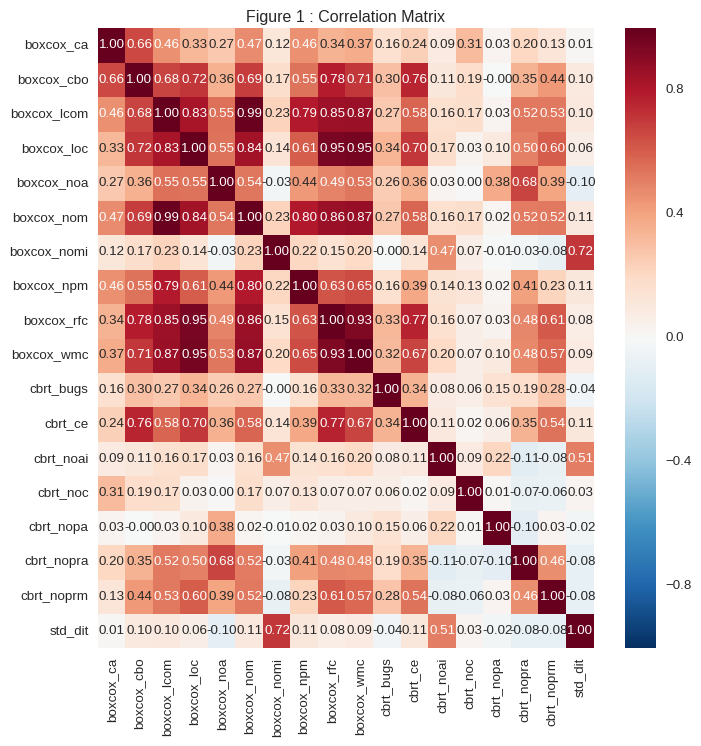

In [4]:
exclude = ['bugs']
corr = sw_metrics.ix[:, sw_metrics.columns.difference(exclude)].corr()
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.title('Figure 1 : Correlation Matrix')
__  = sb.heatmap(corr, annot=True, fmt=".2f")

There is quite a bit of multicollinearity between the features. Considering the sparseness of the number of bugs to the total number of defects within the dataset we will not perform any feature combining or principle component analysis (PCA). There is useful variance between the features that we would like to tease out.  Models that can perform similarly to PCA or models that do not require low multicollinearity will be employed.  

Many of these positive associations between features make sense. 
The metrics Response for a class (RFC) and Lines of Code (LOC) are highly correlated.  The former measures the number of different methods invoked when the interface of the class has one of its methods called.  The larger the call graph, the more lines of code that the class presumably contains.  

Another set of correlated features are Lack of Cohesion in Methods and Weighted Method Count(WMC). WMC is just the total number of methods contained within a class definition. Where each method is weighted by its Cyclometric Complexity. Cyclometric Complexity is the quantitative measure of the number of linearly independent paths through a program's source.  Doubtless that WMC is attempting to measure the amount of effort and/or time needed to develop and maintain the class. Low values are considered better. 

If many methods can be invoked in response to a client’s use of the class interface then testing and debugging of the class becomes more complicated and harder to manage.  It is easy to imagine that a large call graph derived from RFC would correlate to WMC.  


Accuracy on training set: 0.837

Accuracy on test set: 0.831
F1 score :
 [ 0.89955687  0.47286822]


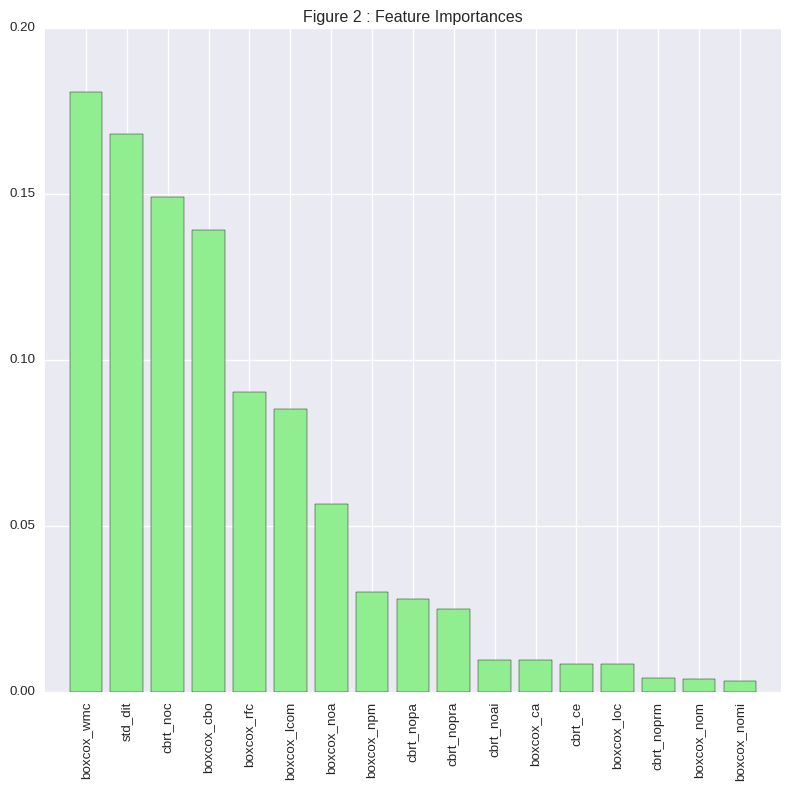

In [7]:
# Feature selection with Random Forest
from sklearn.metrics import f1_score

sw_metrics['bugs_b'] = np.where(sw_metrics.bugs > 0, 1, 0)
y = sw_metrics.bugs_b
X = sw_metrics.drop(['bugs', 'bugs_b', 'cbrt_bugs'], axis=1)

labels = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

rfc = ensemble.RandomForestClassifier(n_estimators=10, max_depth=4, class_weight={0:1, 1:3})
rfc.fit(X_train, y_train)

importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.title('Figure 2 : Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='lightgreen', align='center')
plt.xticks(range(X_train.shape[1]), labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

print("\nAccuracy on training set: {:.3f}".format(rfc.score(X_train, y_train)))

y_ = rfc.predict(X_test)

print("\nAccuracy on test set: {:.3f}".format(rfc.score(X_test, y_test)))
print("F1 score :\n %s" % (f1_score(y_test, y_, average=None)))

For insight into what possible features are more important than others when classifying a defect a Random Forest model was run. Perhaps not surprising all C&K metrics have higher importance than the Object-Oriented ones. The Weighted Methods for Class metric incorporates the number of methods within a class and each method’s cyclometric complexity(CC). The more methods a class has coupled with high values of CC will be harder to test and maintain. How will these feature importances compare to those derived from other models?

## Models

### Baseline Model
Our first step in model selection is the creation of a Baseline Model which all models must improve upon.  The average number of bugs in the dataset is 0.270.  Each model when fed test data, derived from all observations, must at a minimum produce a performace metric better than the average.

### Partial Least Squares Regression

There is a high level of multicollinearity between the features. This is especially the case for those features that incorporate the number of methods, complexity, and lines of code. Partial Least Squares (PLS) using a similar technique as PCA can take a highly multivariate dataset and create a set of orthogonal components.  Hopefully these components can explain almost all of the dataset's variance and reduce the amount of mulitcollinearity.   

PCA is not performed as this would remove the interpretability of which features are better at predicting the number of defects.  Although the number of independent variables is not significantly larger than the number of data points for this dataset employing PLS will allow us to retain the ability to interpret features effect on defect prediction.

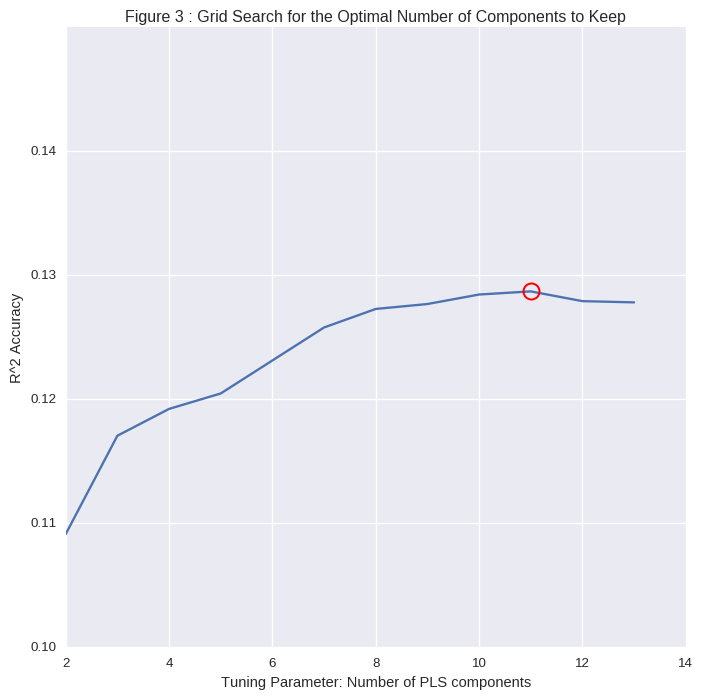

In [8]:
components_range = list(range(2, 14))
param_grid = dict(n_components=components_range)

pls = PLSRegression(n_components=3, scale=False)
grid = GridSearchCV(pls, param_grid, cv=5)
y = sw_metrics.cbrt_bugs
X = sw_metrics.drop(['bugs','bugs_b', 'cbrt_bugs'], axis=1)
grid.fit(X, y)

# check the results of the grid search
grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.10, 0.15])
plt.xlabel('Tuning Parameter: Number of PLS components')
plt.ylabel('R^2 Accuracy')
plt.plot(components_range, grid_mean_scores)
plt.title('Figure 3 : Grid Search for the Optimal Number of Components to Keep')
__ = plt.plot(grid.best_params_['n_components'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

We employ grid search to find the best number of components to keep when running the PLS model. 

In [24]:
mean_bugs = sw_metrics.bugs.mean()
print('Mean number of bugs in dataset: %.3f' % (mean_bugs))
y = sw_metrics.cbrt_bugs
X = sw_metrics.drop(['bugs','bugs_b', 'cbrt_bugs'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
pls = PLSRegression(n_components=11, scale=False)
pls.fit(X_train, y_train)
y_ = pls.predict(X_train)

pls_r_training = pls.score(X_train, y_train)
print("\nR^2 on training set: {:.3f}".format(pls_r_training))
pls_training_RSME = np.sqrt(metrics.mean_squared_error(y_train, y_))
print('PLS RMSE of training set: %.3f\n' % (pls_training_RSME))

pls_r_test = pls.score(X_test, y_test)
print("\nR^2 on test set: {:.3f}".format(pls_r_testing))
y_ = pls.predict(X_test)

pls_test_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_))
print('PLS RMSE of test set: %.3f' % (pls_test_RMSE) )
cbrt_mean_bugs = (np.cbrt(mean_bugs) * np.ones_like(y_test))
#mean_bugs = (mean_bugs * np.ones_like(y_test))

# convert back to original form
baseline_RMSE = np.sqrt(metrics.mean_squared_error(y_test, cbrt_mean_bugs))
print('\nBaseline RMSE: %.3f' % (baseline_RMSE) ) 
print('Baseline RMSE converted to original scale: %.3f' % (baseline_RMSE**3))
converted_pls_test_RMSE = test_RSME**3
print('PLS RMSE of test set converted to original scale: %.3f' % (converted_pls_test_RMSE))
print('\nEstimated betas\n')

for i in np.ndindex(pls.coef_.shape[0]):
    print('%s : %.4f' % (X.columns[i], pls.coef_[i][0]))


Mean number of bugs in dataset: 0.270

R^2 on training set: 0.166
PLS RMSE of training set: 0.599


R^2 on test set: 0.180
PLS RMSE of test set: 0.603

Baseline RMSE: 1.229
Baseline RMSE converted to original scale: 1.855
PLS RMSE of test set converted to original scale: 0.202

Estimated betas

boxcox_wmc : 0.0448
std_dit : -0.0496
cbrt_noc : 0.0552
boxcox_cbo : -0.0347
boxcox_rfc : -0.0279
boxcox_lcom : -0.0371
boxcox_noa : 0.0318
boxcox_npm : -0.0255
cbrt_nopa : 0.1089
cbrt_nopra : 0.0041
cbrt_noai : 0.0889
boxcox_ca : 0.0557
cbrt_ce : 0.1978
boxcox_loc : 0.0897
cbrt_noprm : 0.0737
boxcox_nom : 0.0023
boxcox_nomi : -0.0096


### Nearest Neighbors Regression

Nearest Neighbors Regression makes no assumption about the normality of the features or that there is a low level of multicollinearity.  More importantly, there is no assumption of linearity between the features and the target variable.   First, we run grid search to find the best number of neighbors and then run the model with the select number of neighbors. 

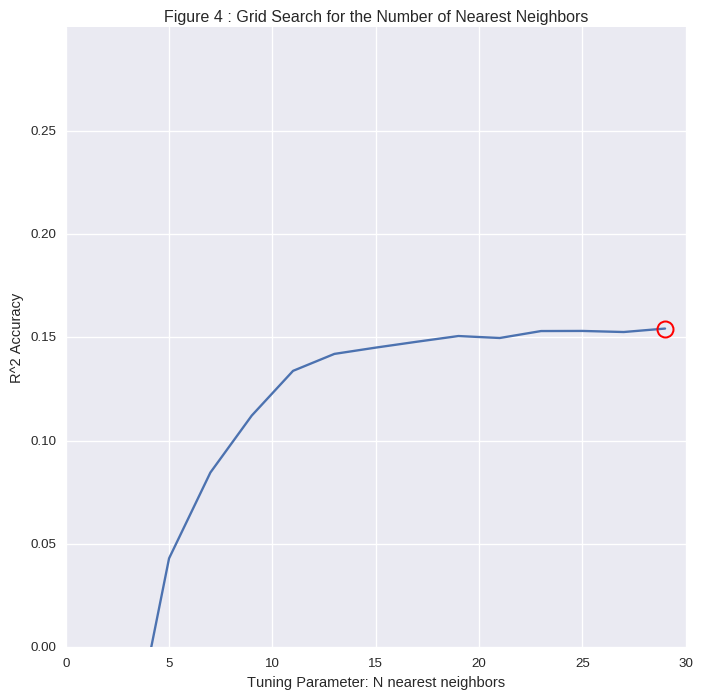

In [9]:
# Let us find the best value for k
knr = neighbors.KNeighborsRegressor()

k_range = list(range(1, 30, 2))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(knr, param_grid, cv=5)
y = sw_metrics.cbrt_bugs
X = sw_metrics.drop(['bugs','bugs_b', 'cbrt_bugs'], axis=1)
grid.fit(X, y)


# check the results of the grid search
grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.0, 0.30])
plt.xlabel('Tuning Parameter: N nearest neighbors')
plt.ylabel('R^2 Accuracy')
plt.plot(k_range, grid_mean_scores)
plt.title('Figure 4 : Grid Search for the Number of Nearest Neighbors')
__ = plt.plot(grid.best_params_['n_neighbors'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

The optimal value for the number of neighbors for the software metrics data is 29.  We now fit the K Neighbors Regression model with the data using the value and see if it performs better than our baseline model. 

In [26]:
print('Mean number of bugs in dataset: %.3f' % (mean_bugs))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
knr = neighbors.KNeighborsRegressor(n_neighbors=29)
knr.fit(X_train, y_train)
y_ = knr.predict(X_train)

knr_r_training = knr.score(X_train, y_train)
print("\nR^2 on training set: {:.3f}".format(knr_r_training))
knr_training_RMSE = np.sqrt(metrics.mean_squared_error(y_train, y_))
print('KNR RMSE of training set: %.3f\n' % (knr_training_RMSE) )

knr_r_test = knr.score(X_test, y_test)
print("\nR^2 on test set: {:.3f}".format(knr_r_test))
y_ = knr.predict(X_test)

knr_test_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_))
print('KNR RMSE of test set: %.3f' % (knr_test_RMSE))
cbrt_mean_bugs = (np.cbrt(mean_bugs) * np.ones_like(y_test))
#mean_bugs = (mean_bugs * np.ones_like(y_test))

# convert back to original form
baseline_RMSE = np.sqrt(metrics.mean_squared_error(y_test, cbrt_mean_bugs))
print('\nBaseline RMSE: %.3f' % (baseline_RMSE) ) 
print('Baseline RMSE converted to original scale: %.3f' % (baseline_RMSE**3))
converted_knr_test_RMSE = knr_test_RSME**3
print('KNR RMSE converted to original scale: %.3f' % (converted_knr_test_RMSE))

Mean number of bugs in dataset: 0.270

R^2 on training set: 0.244
KNR RMSE of training set: 0.571


R^2 on test set: 0.220
KNR RMSE of test set: 0.588

Baseline RMSE: 1.229
Baseline RMSE converted to original scale: 1.855
KNR RMSE converted to original scale: 0.204


The estimated betas are shown to give the strength of the effect of each individual software metric to the number of bugs.  

### Random Forest Regressor

One advantage of a Random Forest model is that it is quite robust to outliers. The metrics dataset has several outliers. These outliers are reasonable considering the context. Software quality various greatly and outliers in the metric values are believable and important to retain. In addition, the model does not assume a linear relationship between the independent variables and the dependent variable. 

We run grid search to find the best maximum depth of the trees limiting the total number of nodes within the binary tree.  

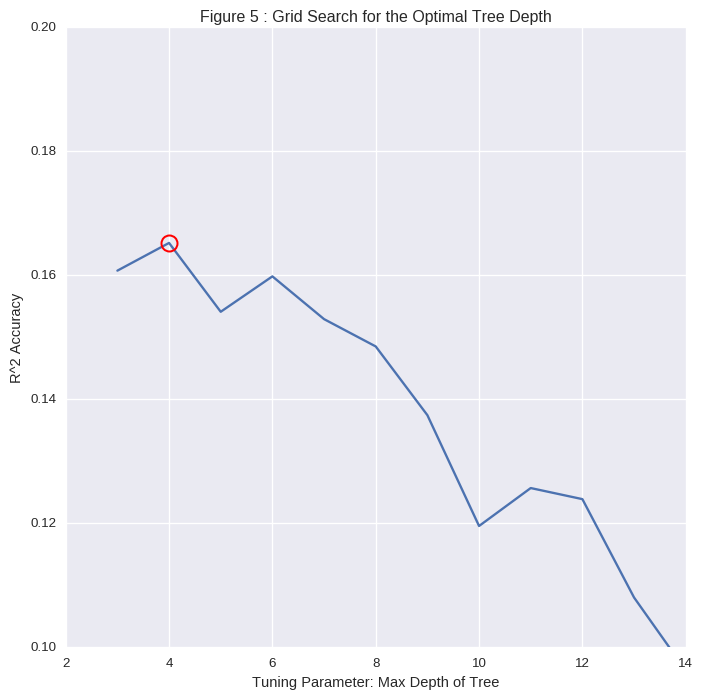

In [12]:
# Let us find the best value for depth of tree
rfr = ensemble.RandomForestRegressor()

max_depth_range = list(range(3, 15))
param_grid = dict(max_depth=max_depth_range)

grid = GridSearchCV(rfr, param_grid, cv=5)
y = sw_metrics.cbrt_bugs
X = sw_metrics.drop(['cbrt_bugs','bugs_b', 'bugs'], axis=1)
grid.fit(X, y)

# check the results of the grid search
grid.grid_scores_
grid.grid_scores_[1]
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.10, 0.20])
plt.xlabel('Tuning Parameter: Max Depth of Tree')
plt.ylabel('R^2 Accuracy')
plt.plot(max_depth_range, grid_mean_scores)
plt.title('Figure 5 : Grid Search for the Optimal Tree Depth')
__ = plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

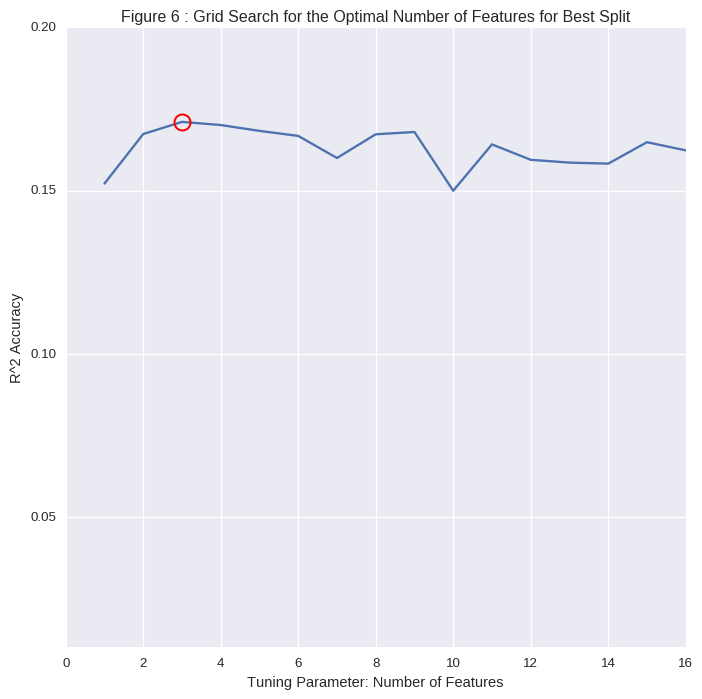

In [13]:
# Let us find the best value for the number of features to consider when looking for the best split
rfr = ensemble.RandomForestRegressor(max_depth=6)

max_features_range = list(range(1, 17))
param_grid = dict(max_features=max_features_range)

grid = GridSearchCV(rfr, param_grid, cv=5)
y = sw_metrics.cbrt_bugs
X = sw_metrics.drop(['cbrt_bugs','bugs_b', 'bugs'], axis=1)
grid.fit(X, y)


# check the results of the grid search
grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_]

# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.01, 0.20])
plt.xlabel('Tuning Parameter: Number of Features')
plt.ylabel('R^2 Accuracy')
plt.plot(max_features_range, grid_mean_scores)
plt.title('Figure 6 : Grid Search for the Optimal Number of Features for Best Split')
__ = plt.plot(grid.best_params_['max_features'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

In [28]:
print('Mean number of bugs in dataset: %.3f' % (mean_bugs))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
rfr = ensemble.RandomForestRegressor(max_features=3, max_depth=6)
rfr.fit(X_train, y_train)
y_ = rfr.predict(X_train)


rfr_r_training = rfr.score(X_train, y_train)
print("\nR^2 on training set: {:.3f}".format(rfr_r_training))
rfr_training_RMSE = np.sqrt(metrics.mean_squared_error(y_train, y_))
print('RFR RMSE of training set: %.3f\n' % (rfr_training_RMSE) )

rfr_r_test = rfr.score(X_test, y_test)
print("\nR^2 on test set: {:.3f}".format(rfr_r_test))
y_ = rfr.predict(X_test)

rfr_test_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_))
print('RFR RMSE of test set: %.3f' % (rfr_test_RMSE))
cbrt_mean_bugs = (np.cbrt(mean_bugs) * np.ones_like(y_test))
#mean_bugs = (mean_bugs * np.ones_like(y_test))

# Lets compute how well the model compares to baseline
baseline_RMSE = np.sqrt(metrics.mean_squared_error(y_test, cbrt_mean_bugs))
print('\nBaseline RMSE: %.3f' % (baseline_RMSE) )
print('Baseline RMSE converted to original scale: %.3f' % (baseline_RMSE**3))

converted_rfr_test_RMSE = rfr_test_RSME**3
print('RFR RMSE converted to original scale: %.3f' % (converted_rfr_test_RMSE))

Mean number of bugs in dataset: 0.270

R^2 on training set: 0.332
RFR RMSE of training set: 0.537


R^2 on test set: 0.225
RFR RMSE of test set: 0.586

Baseline RMSE: 1.229
Baseline RMSE converted to original scale: 1.855
RFR RMSE converted to original scale: 0.202


### Feature Importance

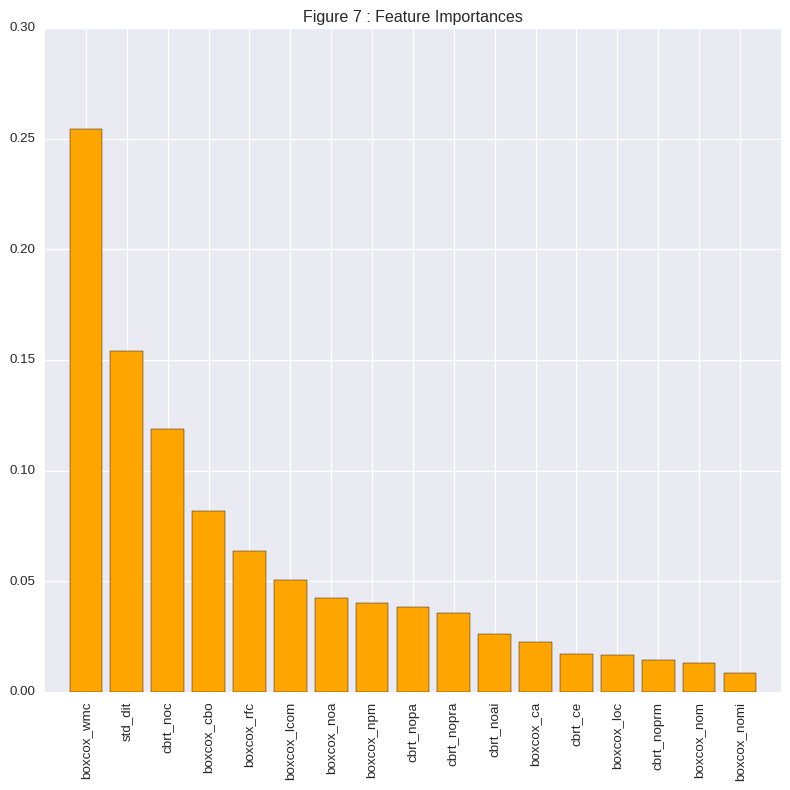

In [17]:
labels = X.columns
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.title('Figure 7 : Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='orange', align='center')
plt.xticks(range(X_train.shape[1]), labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

The feature importance graph depicts some interesting results. Again, we see the metric Weighted Methods per Class and Depth of Inheritance tree (DIT) as the two most important features.   The importance of metrics that measure coupling, cohesion and cyclometric complexity appear to match what Software Engineering considers important when designing and writing good code.  What is surprising is the rank of DIT and Lines of Code (LOC). LOC has been used for years as a simple benchmark in assessing whether a source code file might have other code smells. As the law of Defect Probability states: 'The chance of introducing a defect into your program is proportional to the size of changes made' [6]. 

## Discussion 

In [29]:
# Create results table to make model comparisons easier  
my_dictionary = {'training R^2' : ['NA', pls_r_training, knr_r_training, rfr_r_training],
                 'testing R^2' : ['NA', pls_r_test, knr_r_test, rfr_r_test],
                 'testing RMSE' : [1.229, pls_test_RMSE, knr_test_RMSE, rfr_test_RMSE],
                 'Converted testing RMSE' : [1.885, converted_pls_test_RMSE, converted_knr_test_RMSE, converted_rfr_test_RMSE]}
my_dictionary_df = pd.DataFrame(my_dictionary, index=['Baseline Model', 'Partial Least Squares Regression', 
                                                      'Nearest Neighbors Regression',
                                                      'Random Forest Regression'])
display(my_dictionary_df)

,Converted testing RMSE,testing RMSE,testing R^2,training R^2
Baseline Model,1.885000,1.229000,NA,NA
Partial Least Squares Regression,0.201786,0.603165,0.180426,0.165913
Nearest Neighbors Regression,0.203673,0.588362,0.220161,0.24427
Random Forest Regression,0.202084,0.586471,0.225167,0.331765



There appears to be a weak association between the number of defects and the different software metrics. The PLS model has an R^2 value of 0.180 the model can only account for 18 % if the variance in the dependent variable. The PLS model is only marginally better than the baseline model with an RMSE of 0.603. There is some overfitting with the PLS model.

The K Neighbors Regression model performed slightly better than the Partial Lest Squares model.  Again, there is a slight positive relationship between the software metrics and the number of software defects.  The better performance with this model is perhaps due to the nonlinear relationship between independent and dependent variables. 

With the Random Forest Regression (RFR) model there is a slight amount of overfitting.  This Suggests that the model is perhaps too complex for the data. Again, there is a weak positive association between the features and the target variable. The RFR model performed better than the baseline model or the mean number of defects with the data.  The low R^2 value indicates that the model has a poor measure of fit, while the low RMSE would indicate that the model is accurate in predicting the number of defects.

The heat map above in figure 1 shows that there is a slight positive association between some features and the number of bugs.  All three models reveal a weaker positive relationship than what be suggested via the heatmap and do a fair job at prediction.  The Nearest Neighbors and Random Forest Regression both had marginal better accuracies than the Partial Least Squares. 

## Conclusion

A higher R^2 was expected. The dataset used is not the same set of data used by the authors of the bug prediction benchmarking website. Out of 5,372 observations in the dataset only 863 had a defect of one or more, that is just 16% of observations.The authors used metrics from bi-weekly samples of source code whereas the dataset used for these models is a single snapshot taken at the time these projects were being released. The lower percentage of defects to observations could just be due to improvement of the code prior to going out the door. 

Another explanation for the lower accuracy is the possibility that metric values varied very little as defects were identified and corrected later in the software development life cycle.  The fixing and refactoring of code may not have altered the metrics very much producing metrics that are considered high but at that point of time void of defects. It is also possible that source code with higher metric values do contain defects that were not identified.

An interesting model to attempt for further investigation would be to run Multiple Regression with those features considered important by the Software Engineering community at large (e.g., C&K metrics). The other set of Object Oriented metrics would be dropped from the analysis.

There is agreement within Software Engineering to the usefulness of using metrics to attain the quality of software.  Many have been using tools such Pylint, lint and cpplint for years.  In fact, the use of a static code analysis tool should be used by every software shop as part of their continuous integration step to minimize the chance of introducing software that may have a higher probability of containing defects or hard to manage code. 



## References

1. Chidamber, S.R.; Kemerer, C.F. IEEE Transactions on Software Engineering Volume 20, Issue 6, Jun 1994 Page(s):476 - 493
2. http://bug.inf.usi.ch/index.php
3. An Extensive Comparison of Bug Prediction Approaches Marco D'Ambros, Michele Lanza, Romain Robbes, In Proceedings of MSR 2010 (7th IEEE Working Conference on Mining Software Repositories), pp. 31 - 41. IEEE CS Press, 2010.
4. Cigital, "Case study: Finding defects earlier yields enormous savings," Available at www.cigital.com, 2003
5. http://www.virtualmachinery.com/sidebar3.htm
6. Kanat-Alexander, Max. 2012. Code Simplicity, O'Reilly Media
